<a href="https://colab.research.google.com/github/mz-zarei/NBEB-Sensitivity/blob/main/NBEB_sensitivity_Application.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import nbeb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def PMD(results):
    PMD_test = 0
    for HS_level in [0.1]:
        PMD_test += results[results['true_rank'] > 1-HS_level]['PSI_true'].sum() - results[results['rank'] > 1-HS_level]['PSI_true'].sum()
    return round(PMD_test,3)

def FI(results):
    FI_test = 0
    for HS_level in [0.1]:
        FI_test += 1-results[(results['true_rank'] > 1- HS_level) & (results['rank'] > 1- HS_level)].count()[0]/results[(results['rank'] > 1- HS_level)].count()[0]
    return round(FI_test, 3)

def truncnorm(AADT_list, noise):
    AADT_n = []
    
    for mean in AADT_list:
        if noise > 0:
            sd = mean * noise
            minS = max(40, mean - 2*sd)
            maxS = mean + 2*sd
            while True:
                s = np.random.normal(mean, sd)
                if minS <= s <= maxS:
                    break
            AADT_n.append(s)  
        else:
            AADT_n.append(mean)


    return AADT_n


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
### Upload data
London_data = pd.read_excel('/content/London_Python_Data.xlsx')
London_data = London_data[London_data['Year'] == 2016].copy()
# London_data = London_data[London_data['Group'] == 3].copy()

London_data['log_Fmaj'] = np.log(London_data['Fmaj'])
London_data['log_Fmin'] = np.log(London_data['Fmin'])
London_data['log_Ftot'] = np.log(London_data['Ftot'])
features = ['log_Ftot'] #  ['log_Fmaj', 'log_Fmin'] # 
features_n = ['log_Ftot_n'] # ['log_Fmaj_n', 'log_Fmin_n'] # 
London_data.reset_index(inplace=True, drop= True)
London_data.describe()

,Group,Year,Fmaj,Fmin,Ftot,Fatal,Non-fatal,PDO,FI,Obs,log_Fmaj,log_Fmin,log_Ftot
count,865.000000,865.0,865.000000,865.000000,865.000000,865.0,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000
mean,2.475145,2016.0,14793.060116,3625.870520,18418.930636,0.0,0.634682,3.122543,0.634682,3.757225,9.088870,7.429977,9.340081
std,1.260013,0.0,11391.583183,4995.177649,14438.160766,0.0,1.205965,6.131753,1.205965,7.028630,1.232232,1.334653,1.170956
min,1.000000,2016.0,168.000000,7.000000,306.000000,0.0,0.000000,0.000000,0.000000,0.000000,5.123964,1.945910,5.723585
25%,1.000000,2016.0,3911.000000,677.000000,4968.000000,0.0,0.000000,0.000000,0.000000,0.000000,8.271548,6.517671,8.510773
50%,3.000000,2016.0,12851.000000,1805.000000,15997.000000,0.0,0.000000,1.000000,0.000000,1.000000,9.461177,7.498316,9.680156
75%,4.000000,2016.0,24108.000000,4297.000000,28340.000000,0.0,1.000000,3.000000,1.000000,4.000000,10.090299,8.365672,10.252030
max,4.000000,2016.0,46121.000000,33450.000000,73035.000000,0.0,8.000000,56.000000,8.000000,62.000000,10.739024,10.417807,11.198694


In [3]:
nb_models = []
alpha_list = []
for g in range(1,5):
        London_data_G = London_data[London_data['Group'] == g].copy()
        NB_model_b, alpha = nbeb.fitNB(London_data_G,features=features, y_name='Obs')
        print(alpha, "\n", NB_model_b.summary(), NB_model_b.params[0])
        # print(London_data_G['Obs'].mean(), len(London_data_G['Ftot']))
        nb_models.append(NB_model_b)
        alpha_list.append(alpha)


0.19903761417090224 
                  Generalized Linear Model Regression Results                  
Dep. Variable:                    Obs   No. Observations:                  315
Model:                            GLM   Df Residuals:                      313
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -896.34
Date:                Thu, 07 Apr 2022   Deviance:                       504.73
Time:                        19:03:16   Pearson chi2:                     513.
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -15.2708      0.8

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [13]:

noiseList = [0, 0.2, 0.4, 0.6, 0.8, 1]

FI_list  = []
PMD_list = []
FI_noNoise_list  = []
PMD_noNoise_list = []
nosie_list = []

for j in tqdm(range(250)):
    simulated_data = pd.DataFrame()
    for NB_model_b, alpha, g in zip(nb_models, alpha_list, [1,2,3,4]):
        London_data_G = London_data[London_data['Group'] == g].copy()
        simulated_data_g = nbeb.simulateCrashData_X(London_data_G[features], 
                                                constant = NB_model_b.params[0], 
                                                coef_vector = [NB_model_b.params[1]], 
                                                data_size =  len(London_data_G[features]), 
                                                error_mean = 1.0,
                                                error_var = alpha,
                                                replacement = False)


        NB_model, alpha                  = nbeb.fitNB(simulated_data_g,features=features, y_name='Obs')
        simulated_data_g['Group']        = g
        simulated_data_g['NB_pred']      = nbeb.predNB(NB_model, simulated_data_g, features, 'Obs')
        simulated_data_g['NB_pred_true'] = nbeb.predNB(NB_model_b, simulated_data_g, features, 'Obs')
        simulated_data_g['w']            = 1 / (1+alpha * simulated_data_g['NB_pred'])
        
        simulated_data_g['EB'] = simulated_data_g['w'] * simulated_data_g['NB_pred']  + (1-simulated_data_g['w']) * simulated_data_g['Obs']
        simulated_data_g['PSI'] = simulated_data_g['EB'] - simulated_data_g['NB_pred']
        simulated_data_g.loc[simulated_data_g['PSI']<0,'PSI'] = 0

        simulated_data = pd.concat([simulated_data, simulated_data_g])

    simulated_data['Ftot'] = np.exp(simulated_data['log_Ftot'])
    simulated_data['rank'] = simulated_data['PSI'].rank(pct=True)
    simulated_data['PSI_true'] = simulated_data['Lambda'] - simulated_data['NB_pred_true']
    simulated_data.loc[simulated_data['PSI_true']<0, 'PSI_true'] = 0
    simulated_data['true_rank'] = simulated_data['PSI_true'].rank(pct=True)

    FI_NoNoise = FI(simulated_data)
    PMD_NoNoise = PMD(simulated_data)

    
    for i in range(1):
        for noise in noiseList:


            simulated_data['Ftot_n'] = truncnorm(simulated_data['Ftot'].values, noise)
            simulated_data['log_Ftot_n'] = np.log(simulated_data['Ftot_n'])

            simulated_data_n = pd.DataFrame()
            for g in [1,2,3,4]:
                simulated_data_g = simulated_data[simulated_data['Group'] == g].copy()
                NB_model, alpha = nbeb.fitNB(simulated_data_g,features=features_n, y_name='Obs')
                simulated_data_g['NB_pred'] = nbeb.predNB(NB_model, simulated_data_g, features_n, 'Obs')
                simulated_data_g['w'] = 1 / (1+alpha * simulated_data_g['NB_pred'])
                # change EB be PSI
                simulated_data_g['EB'] = simulated_data_g['w'] * simulated_data_g['NB_pred']  + (1-simulated_data_g['w']) * simulated_data_g['Obs']
                simulated_data_g['PSI'] = simulated_data_g['EB'] - simulated_data_g['NB_pred'] 
                simulated_data_g.loc[simulated_data_g['PSI']<0,'PSI'] = 0

                simulated_data_n = pd.concat([simulated_data_n, simulated_data_g])


            
            simulated_data['rank'] = simulated_data_n['PSI'].rank(pct=True)
          
            
            FI_test  = FI(simulated_data)
            PMD_test = PMD(simulated_data)
            
            FI_list.append((FI_test))
            PMD_list.append((PMD_test))

            FI_noNoise_list.append((FI_NoNoise))
            PMD_noNoise_list.append((PMD_NoNoise))

            nosie_list.append(noise)



  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
100%|██████████| 250/250 [03:37<00:00,  1.15it/s]


In [36]:
Test_results = pd.DataFrame()

Test_results['COV (%)'] = nosie_list
Test_results['COV (%)'] = Test_results['COV (%)'] * 100

Test_results['FI'] = FI_list
Test_results['FI_NoNoise'] = FI_noNoise_list
Test_results['FI change (%)'] = (Test_results['FI']-Test_results['FI_NoNoise'])/Test_results['FI_NoNoise'] * 100

Test_results['DPSI'] = PMD_list
Test_results['DPSI_NoNoise'] = PMD_noNoise_list
Test_results['Loss Change ($)'] = 15000*(Test_results['DPSI']-Test_results['DPSI_NoNoise'])
Test_results['DPSI AVG Change (%)'] = (Test_results['DPSI']-Test_results['DPSI_NoNoise'])/Test_results['DPSI_NoNoise'] * 100


Test_results.to_excel('test.xlsx')
Test_results

,COV (%),FI,FI_NoNoise,FI change (%),DPSI,DPSI_NoNoise,Loss Change ($),DPSI AVG Change (%)
0,0.0,0.379,0.379,0.000000,82.743,82.743,0.0,0.000000
1,20.0,0.460,0.379,21.372032,106.109,82.743,350490.0,28.239247
2,40.0,0.448,0.379,18.205805,100.487,82.743,266160.0,21.444714
3,60.0,0.437,0.379,15.303430,102.844,82.743,301515.0,24.293294
4,80.0,0.471,0.379,24.274406,117.863,82.743,526800.0,42.444678
...,...,...,...,...,...,...,...,...
1495,20.0,0.322,0.310,3.870968,77.433,69.394,120585.0,11.584575
1496,40.0,0.356,0.310,14.838710,85.294,69.394,238500.0,22.912644
1497,60.0,0.333,0.310,7.419355,85.278,69.394,238260.0,22.889587
1498,80.0,0.356,0.310,14.838710,90.783,69.394,320835.0,30.822549


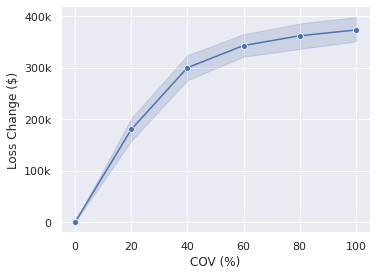

In [38]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

Test_results = pd.read_excel('/content/test.xlsx')

sns.set(font_scale=1)
fig = sns.relplot(data=Test_results, x="COV (%)", y="Loss Change ($)", kind="line", height=4, aspect=1.4, marker = 'o')
plt.yticks([ 0, 100000, 200000,300000, 400000], ['0','100k','200k', '300k', '400k'])
fig.savefig('Loss_L.pdf')

plt.show()



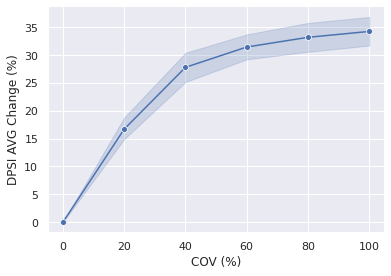

In [39]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

Test_results = pd.read_excel('/content/test.xlsx')
sns.set(font_scale=1)

fig = sns.relplot(data=Test_results, x="COV (%)", y="DPSI AVG Change (%)", kind="line", height=4, aspect=1.4, marker = 'o')

fig.savefig('DPSI_L.pdf')

plt.show()